# Calibración del polarizador


**Autor**: Luis Miguel Sánchez Brea.

**Fecha**: 01/07/2019.

**Objetivo**: Puesta a punto de SLM.

**Descripción**: Se pretende ubicar adecuadamente el polarizador, moviendolo manualmente

* Se pone una imagen conocida
* se abre la cámara
* se ubica 

In [1]:
%run config_jupyter.ipynb
%matplotlib inline

In [2]:
import time
from pprint import pprint
import cv2
import screeninfo

In [3]:
from diffractio import degrees, mm, plt, sp, um, np
from diffractio.scalar_masks_XY import Scalar_mask_XY

In [4]:
from py_slm.smc100 import SMC100
import py_slm.camera.tisgrabber as IC
from py_slm.py_slm import SLM
from py_slm.config import CONF_HOLOEYE2500, CONF_PACKARD_BELL, CONF_IMAGING_SOURCE
from py_slm.config import z_ini, amplification_4f, wavelength

In [5]:
s=1.

### Cargar modulador

In [6]:
import screeninfo
screeninfo.get_monitors()

[monitor(1440x900+0+0), monitor(1024x768+1440+0)]

In [7]:
slm=SLM(config_SLM=CONF_HOLOEYE2500, config_Camera=CONF_IMAGING_SOURCE)

x0=slm.x0
y0=slm.y0
wavelength=slm.wavelength
print(x0.shape, y0.shape)

((1024L,), (768L,))


In [8]:
tamano_slm=1*mm

(<Figure size 360x324 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x10c13630>)

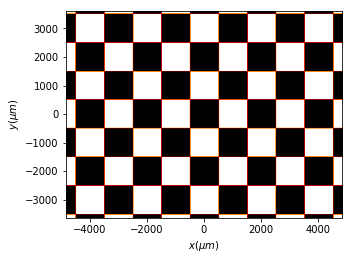

In [28]:
t = Scalar_mask_XY(slm.x0, slm.y0, slm.wavelength)
t.square(r0=(0,0), size=(tamano_slm,tamano_slm), angle=0*degrees)
t.grating_2D_ajedrez(period=2000*um, amin=0,   amax=1., phase=0,
                   x0=0, fill_factor=0.5,   angle=0.0 * degrees)
t.draw(kind='intensity')

### Cargar lente en modulador

In [29]:
"Creamos la imagen a partir de la máscara creada."
slm.mask_to_rawImage(mask_XY=t, kind='intensity', normalize=True);

In [30]:
"Enviamos la imagen al SLM."
slm.send_image_screen()
cv2.waitKey(500)

-1

### Cargar motor

In [12]:
has_move_motor=False

In [13]:
if has_move_motor is True:
    smc100 = SMC100(1, 'COM3', silent=True)
    smc100.set_velocity(20*mm/s, check=True)
    smc100.home()
    smc100.move_absolute(z_ini)

### Cargar camara

In [14]:
has_camera=False
is_life = False

In [15]:
if has_camera is True:
    #Create the camera object.
    Camera = IC.TIS_CAM()
    Camera.open("DMx 72BUC02 14210296")
    # Set a video format
    Camera.SetVideoFormat("Y800 (2592x1944)")
    Camera.SetVideoFormat("Y800 (1024x768)")

    #Set a frame rate of 30 frames per second
    Camera.SetFrameRate(5)
    if is_life is True:
        Camera.StartLive(1)
    else:
        Camera.StartLive(0)

In [16]:
gain_value=3
exposure_value=-7

In [17]:
if has_camera is True:
    Camera.SetPropertySwitch("Gain", "Auto", 0)
    Camera.SetPropertySwitch("Exposure", "Auto", 0)
    Camera.SetPropertyValue("Gain", "Value", gain_value)
    Camera.SetPropertyValue("Exposure", "Value", exposure_value)

## Procedimiento de calibración

In [18]:
pixel_size=CONF_IMAGING_SOURCE['size_pixels']
num_pixels=CONF_IMAGING_SOURCE['num_pixels']

campo_x=pixel_size[0]*num_pixels[0]
campo_y=pixel_size[1]*num_pixels[1]

print(campo_x,campo_y, num_pixels)

(2252.8, 1689.6000000000001, (1024, 768))


In [19]:
x_camera=np.linspace(-campo_x/2,campo_x/2,num_pixels[0])
y_camera=np.linspace(-campo_y/2,campo_y/2,num_pixels[1])

print(x_camera[0],x_camera[-1],y_camera[0],y_camera[-1])

(-1126.4, 1126.4, -844.8000000000001, 844.8000000000001)


In [20]:
print(x_camera[1]-x_camera[0],y_camera[1]-y_camera[0])

(2.202150537634452, 2.202868318122569)


In [21]:
image_camera=Scalar_mask_XY(x=x_camera, y=y_camera, wavelength=wavelength)


In [22]:
Camera=slm.camera1
Camera.SetPropertyValue("Exposure", "Value", -5)

1

In [23]:
Camera.SnapImage()
image = Camera.GetImage()

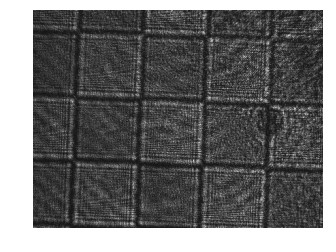

In [24]:
plt.figure()
plt.imshow(np.flipud(image))
plt.axis('off');

In [25]:
intensidad=(image[:,:,0])
intensidad.shape
intensidad = intensidad.astype('float') 

In [26]:
image_camera.u=np.sqrt(intensidad)

In [27]:
%matplotlib inline

horizontal


(<Figure size 360x324 with 2 Axes>,
 <matplotlib.image.AxesImage at 0xd698828>)

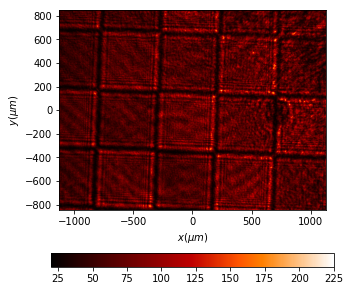

In [28]:
image_camera.draw(has_colorbar='horizontal')

(512, 512, 0, 767)


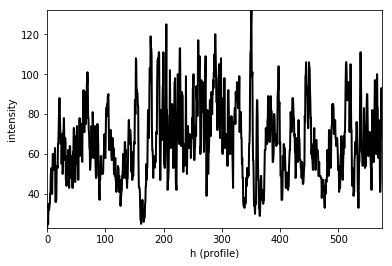

In [29]:
image_camera.draw_profile(point1=(-0,-880),
                     point2=(-0,880),
                     npixels=1024,
                     kind='intensity',
                     order=0);

(0, 1023, 384, 384)


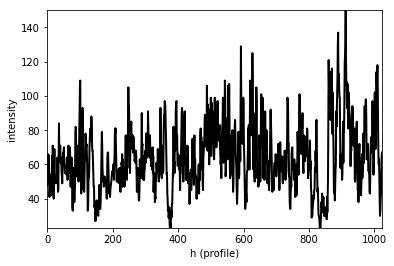

In [30]:
image_camera.draw_profile(point1=(-1300,0),
                     point2=(1300,0),
                     npixels=1024,
                     kind='intensity',
                     order=0);

In [31]:
percentaje_saturated=sum(sum(intensidad==255))/(len(x0)*len(y0)+0.001)*100

In [35]:
print(percentaje_saturated)

0.0
